# Análise de Fadiga em Componentes Aeronáuticos

Este notebook apresenta uma análise dos dados estruturais de uma fuselagem aeronáutica, focando no comportamento de fadiga e avaliação preditiva com KNN e Árvore de Decisão.

In [4]:
!pip install -q pandas seaborn matplotlib scikit-learn

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Carregar a base de dados
df = pd.read_csv("aircraft_fatigue.csv")
df.head()

,EID,type,material,stress_landing,stress_taxi,stress_lateral,stress_vertical,stress_pressurization,life,log_life
0,1,skin,1,-0.160388,-0.148503,1.804565,1.24634,2.832018,58204.451435,4.764956
1,2,skin,2,11.403720,4.825349,11.831360,12.24992,9.349614,3.772988,0.576685
2,3,skin,2,11.490120,4.799707,10.220180,10.51033,8.728369,10.534143,1.022599
3,4,skin,2,11.796380,4.957905,10.902360,10.82325,7.964283,7.243898,0.859972
4,5,skin,2,10.877260,4.495966,10.187770,10.85074,8.749962,7.870671,0.896012


In [6]:
# Estatísticas básicas e tipos
print("Estatísticas descritivas:")
display(df.describe())
print("\nTipos de dados:")
display(df.dtypes)
print("\nValores únicos por coluna:")
display(df.nunique())
print("\nMatriz de correlação:")
display(df.corr(numeric_only=True))

Estatísticas descritivas:


,EID,material,stress_landing,stress_taxi,stress_lateral,stress_vertical,stress_pressurization,life,log_life
count,21635.000000,21635.000000,21635.000000,21635.000000,21635.000000,21635.000000,21635.000000,2.163500e+04,21635.000000
mean,10818.000000,1.711902,2.748109,1.445649,5.297806,5.282558,4.636918,5.092113e+17,3.757733
std,6245.630873,0.870385,3.440907,1.947720,4.510504,4.528405,4.005871,5.035092e+19,3.118429
min,1.000000,1.000000,-8.509144,-5.918386,-11.586440,-11.740950,-11.012150,6.636866e-02,-1.178037
25%,5409.500000,1.000000,0.243823,-0.009556,1.815565,1.672957,1.551748,2.242214e+01,1.350677
50%,10818.000000,1.000000,1.880849,0.931252,4.965043,5.052733,4.111456,7.524306e+02,2.876466
75%,16226.500000,3.000000,5.238305,3.129730,8.323815,8.400724,7.467462,2.575979e+05,5.410942
max,21635.000000,3.000000,13.468960,9.852309,31.582030,31.589610,31.219330,6.076139e+21,21.783628



Tipos de dados:


EID                        int64
type                      object
material                   int64
stress_landing           float64
stress_taxi              float64
stress_lateral           float64
stress_vertical          float64
stress_pressurization    float64
life                     float64
log_life                 float64
dtype: object


Valores únicos por coluna:


EID                      21635
type                         2
material                     3
stress_landing           21615
stress_taxi              21592
stress_lateral           21616
stress_vertical          21611
stress_pressurization    21615
life                     21635
log_life                 21635
dtype: int64


Matriz de correlação:


,EID,material,stress_landing,stress_taxi,stress_lateral,stress_vertical,stress_pressurization,life,log_life
EID,1.000000,0.620222,-0.304219,-0.225133,-0.518669,-0.519315,-0.555954,0.017317,0.531676
material,0.620222,1.000000,0.094169,0.024149,-0.318375,-0.321223,-0.440788,0.014967,0.428162
stress_landing,-0.304219,0.094169,1.000000,0.907096,0.593534,0.625081,0.356123,-0.008557,-0.547755
stress_taxi,-0.225133,0.024149,0.907096,1.000000,0.571610,0.605364,0.330149,-0.008254,-0.515370
stress_lateral,-0.518669,-0.318375,0.593534,0.571610,1.000000,0.983685,0.928917,-0.017430,-0.848650
stress_vertical,-0.519315,-0.321223,0.625081,0.605364,0.983685,1.000000,0.923778,-0.017370,-0.857150
stress_pressurization,-0.555954,-0.440788,0.356123,0.330149,0.928917,0.923778,1.000000,-0.017764,-0.810164
life,0.017317,0.014967,-0.008557,-0.008254,-0.017430,-0.017370,-0.017764,1.000000,0.057848
log_life,0.531676,0.428162,-0.547755,-0.515370,-0.848650,-0.857150,-0.810164,0.057848,1.000000


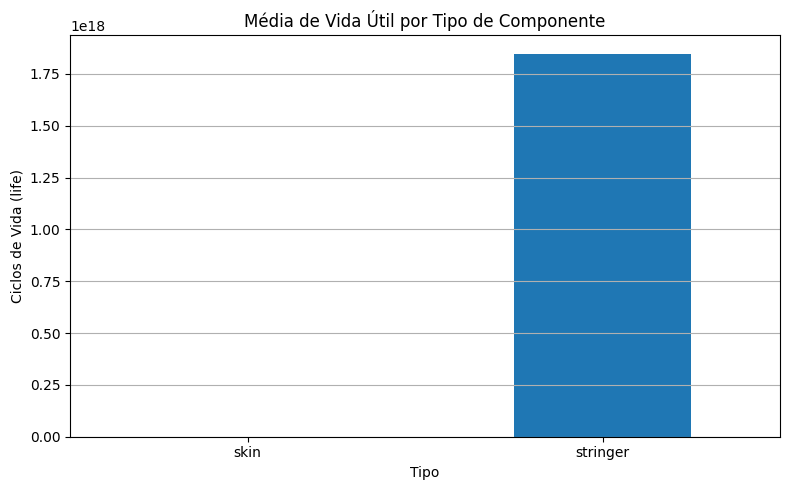

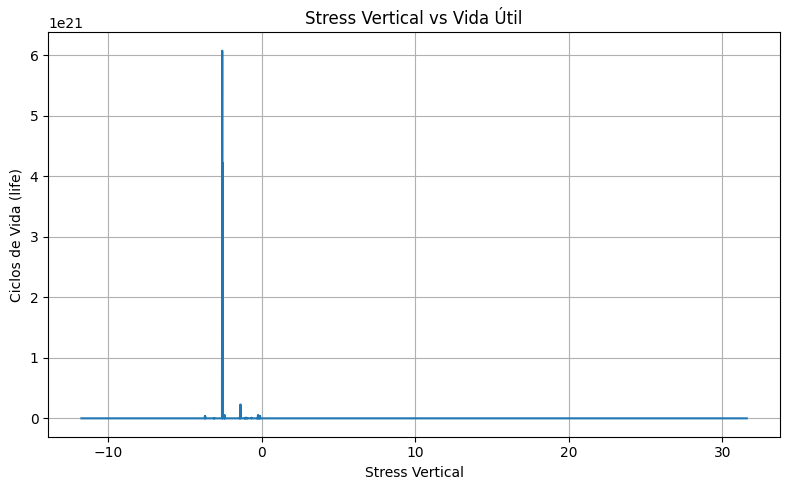

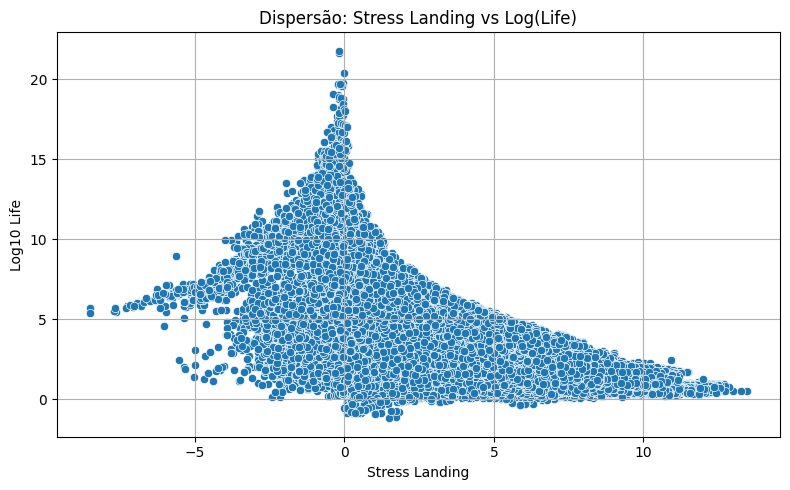

In [7]:
# Análise exploratória

# Gráfico de barras: média de 'life' por tipo de componente
plt.figure(figsize=(8, 5))
df.groupby('type')['life'].mean().plot(kind='bar')
plt.title('Média de Vida Útil por Tipo de Componente')
plt.ylabel('Ciclos de Vida (life)')
plt.xlabel('Tipo')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Gráfico de linha: relação entre stress vertical e vida
plt.figure(figsize=(8, 5))
sns.lineplot(data=df.sort_values('stress_vertical'), x='stress_vertical', y='life')
plt.title('Stress Vertical vs Vida Útil')
plt.ylabel('Ciclos de Vida (life)')
plt.xlabel('Stress Vertical')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico de dispersão: stress_landing vs log_life
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='stress_landing', y='log_life')
plt.title('Dispersão: Stress Landing vs Log(Life)')
plt.xlabel('Stress Landing')
plt.ylabel('Log10 Life')
plt.grid(True)
plt.tight_layout()
plt.show()

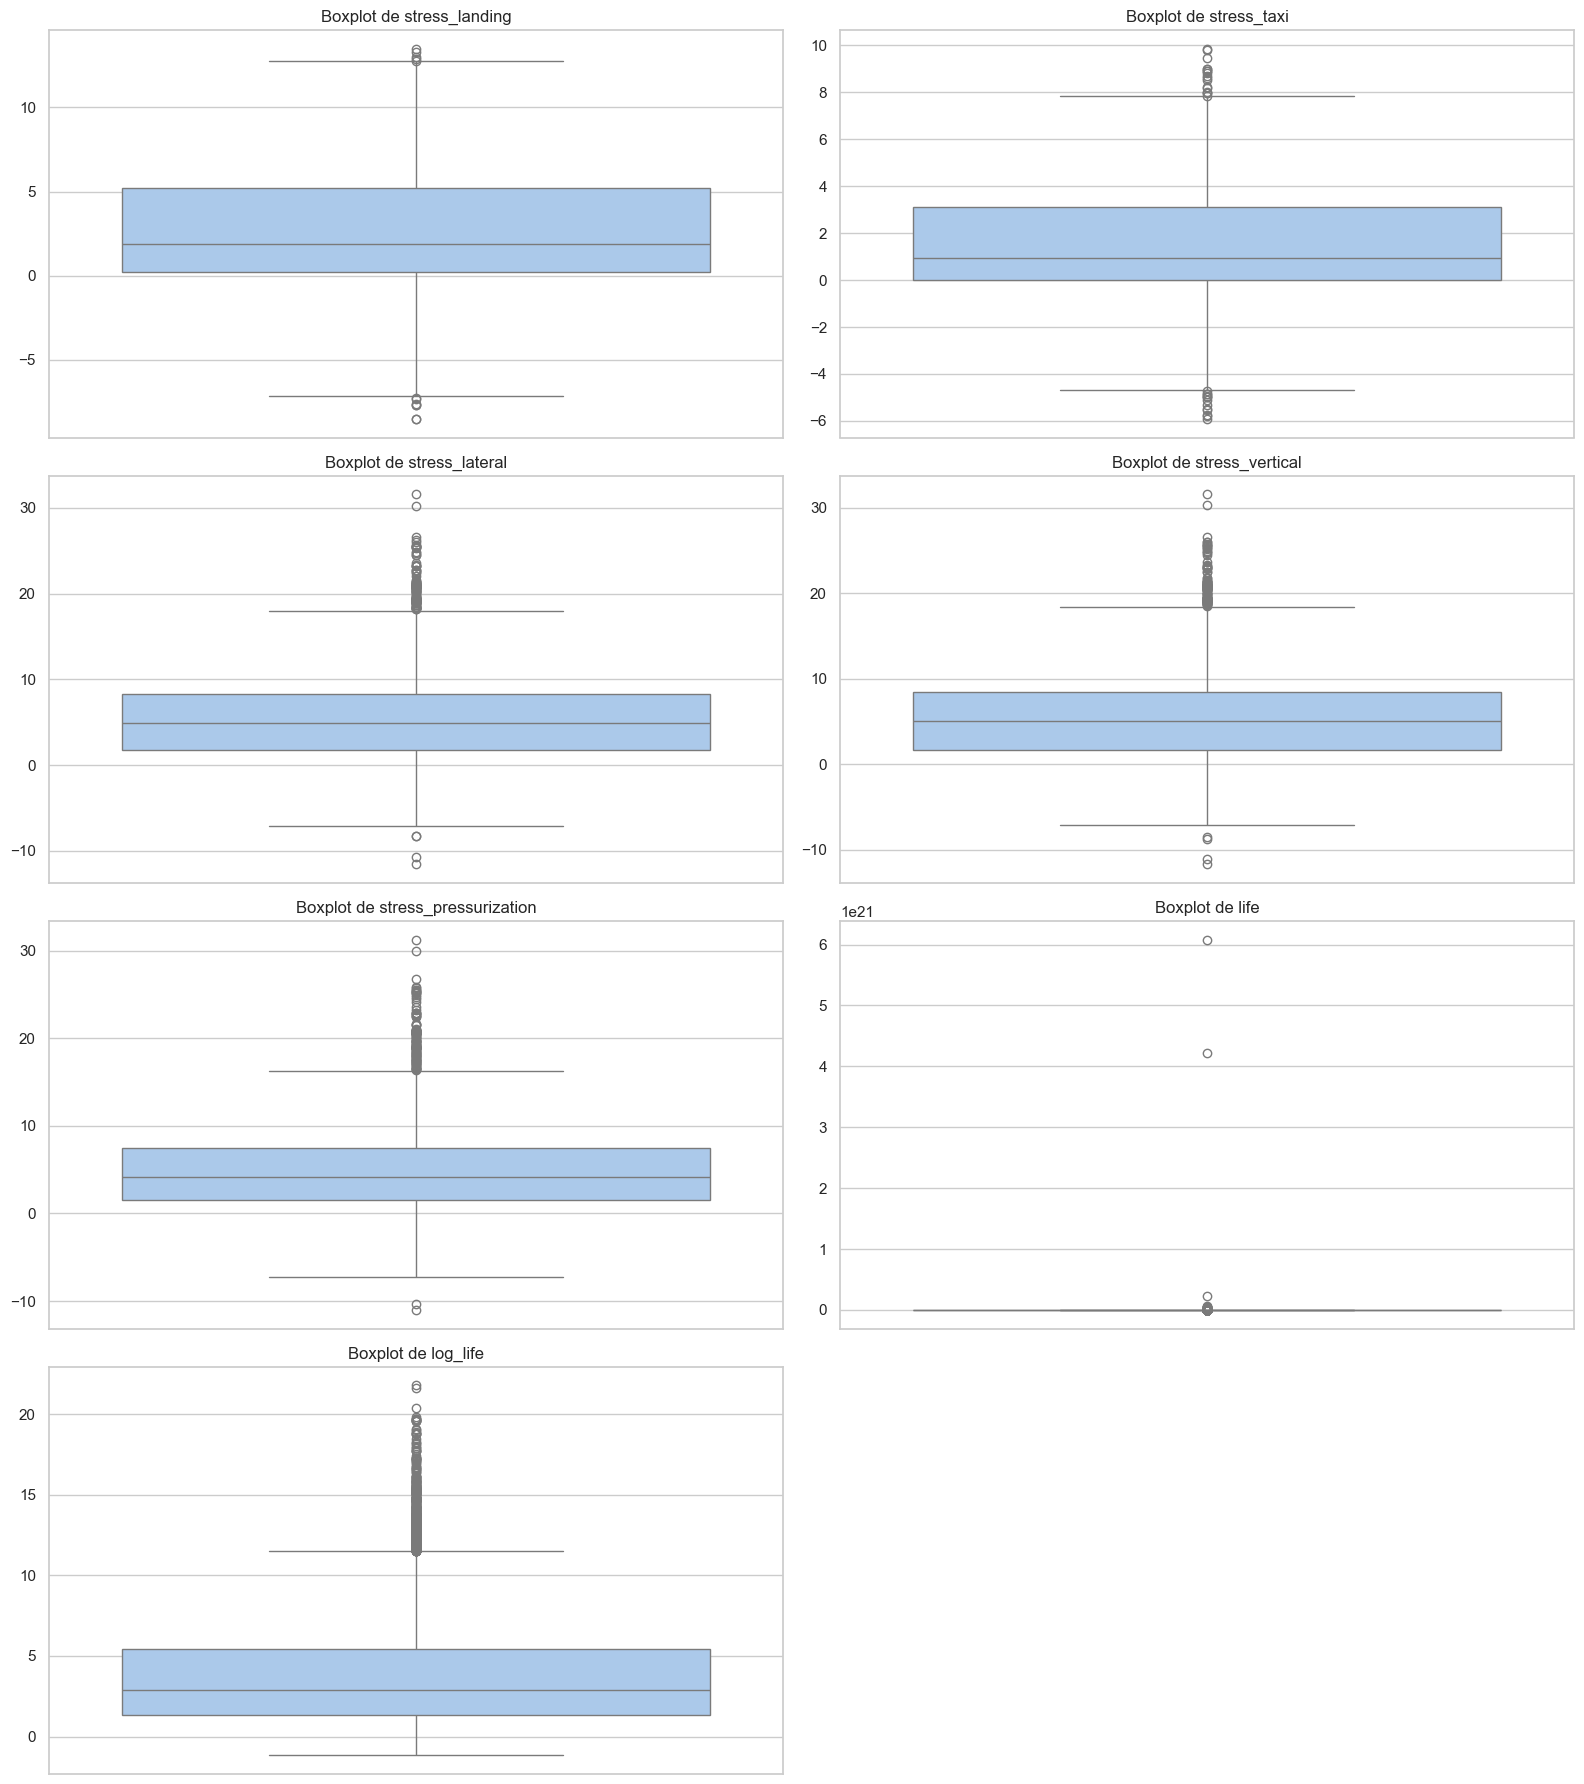

In [8]:
# verificar possiveis outliers
# Boxplots para variáveis numéricas
numeric_cols = ['stress_landing', 'stress_taxi', 'stress_lateral', 'stress_vertical', 'stress_pressurization', 'life', 'log_life']
sns.set(style="whitegrid", palette="pastel")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 18))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
# Pré-processamento
df = df.drop(columns=['EID'], errors='ignore')

# Codificar 'type' como numérico
if df['type'].dtype == 'object':
    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])

# One-hot encoding para 'material'
df = pd.get_dummies(df, columns=['material'], drop_first=True)

# Reescalonamento de colunas de stress
stress_cols = [col for col in df.columns if 'stress' in col]
scaler = MinMaxScaler(feature_range=(-1, 1))
df[stress_cols] = scaler.fit_transform(df[stress_cols])

# Criar duas versões da base
df_no_trunc = df.copy()
df_trunc = df.copy()
df_trunc['life'] = df_trunc['life'].apply(lambda x: min(x, 1e5))

In [10]:
# Função para treinar e avaliar os modelos
def train_and_evaluate(df_input, model, model_name, truncado):
    X = df_input.drop(columns=['life'])
    y = df_input['life']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {
        "Modelo": model_name,
        "Truncado": truncado,
        "MSE": mse,
        "R²": r2
    }

In [11]:
# Avaliação dos modelos
results = []
results.append(train_and_evaluate(df_no_trunc, KNeighborsRegressor(), "KNN", "Não"))
results.append(train_and_evaluate(df_trunc, KNeighborsRegressor(), "KNN", "Sim"))
results.append(train_and_evaluate(df_no_trunc, DecisionTreeRegressor(random_state=42), "Árvore de Decisão", "Não"))
results.append(train_and_evaluate(df_trunc, DecisionTreeRegressor(random_state=42), "Árvore de Decisão", "Sim"))

results_df = pd.DataFrame(results)
results_df

,Modelo,Truncado,MSE,R²
0,KNN,Não,6.134547e+39,0.280999
1,KNN,Sim,4.885260e+05,0.999752
2,Árvore de Decisão,Não,7.909934e+38,0.907291
3,Árvore de Decisão,Sim,1.364191e+03,0.999999


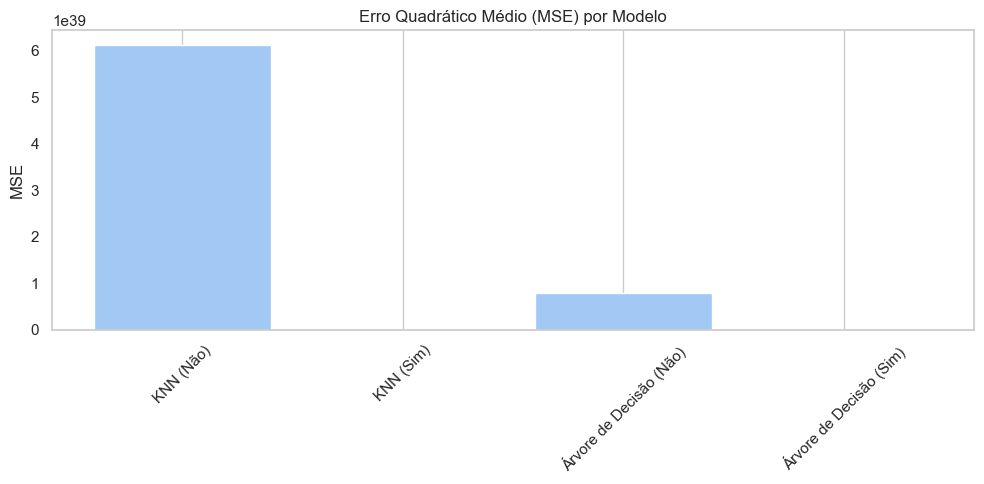

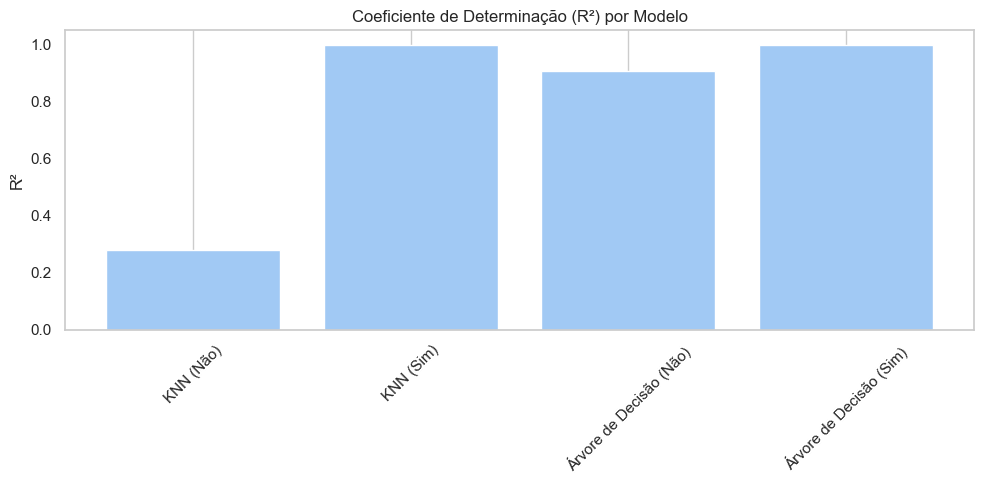

In [12]:
# Visualização dos resultados
plt.figure(figsize=(10, 5))
plt.bar(results_df["Modelo"] + " (" + results_df["Truncado"] + ")", results_df["MSE"])
plt.title("Erro Quadrático Médio (MSE) por Modelo")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(results_df["Modelo"] + " (" + results_df["Truncado"] + ")", results_df["R²"])
plt.title("Coeficiente de Determinação (R²) por Modelo")
plt.ylabel("R²")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

A versão truncada apresentou desempenho significativamente superior, principalmente no modelo de árvore de decisão, que alcançou praticamente um R² igual a 1.



